# connect to db

In [1]:
server = 'ds059694.mongolab.com'
port = 59694
db_name = 'deepreader'
username = 'deepreaderuser'
password = '1ecolequimonte45'

from pymongo import MongoClient as Connection

# from pymongo import Connection

# what versions are we using
import sys
print 'Python version', sys.version

import pymongo
print 'Pymongo version', pymongo.version
##

# connect to server
print '\nConnecting ...'
conn = Connection(server, port)

# Get the database
print '\nGetting database ...'
db = conn[db_name]

# Have to authenticate to get access
print '\nAuthenticating ...'
db.authenticate(username, password)

Python version 2.7.10 |Anaconda 2.3.0 (64-bit)| (default, Nov  7 2015, 13:18:40) [MSC v.1500 64 bit (AMD64)]
Pymongo version 3.1.1

Connecting ...

Getting database ...

Authenticating ...


True

# get graph from db

In [2]:
graph = db.graph.find_one()
print graph.keys()

[u'nodes', u'_id', u'links']


In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18.0, 12.0)
import networkx as nx

G = nx.Graph()
nodes = graph['nodes']
edges = graph['links']
for n in nodes:
    G.add_node(n['id'])

for e in edges:
    a = e['source']
    b = e['target']
    G.add_edge(a,b )
    

In [4]:
# >>> import networkx as nx
# >>> G=nx.Graph()
# >>> G.add_node("spam")
# >>> G.add_edge(1,2)


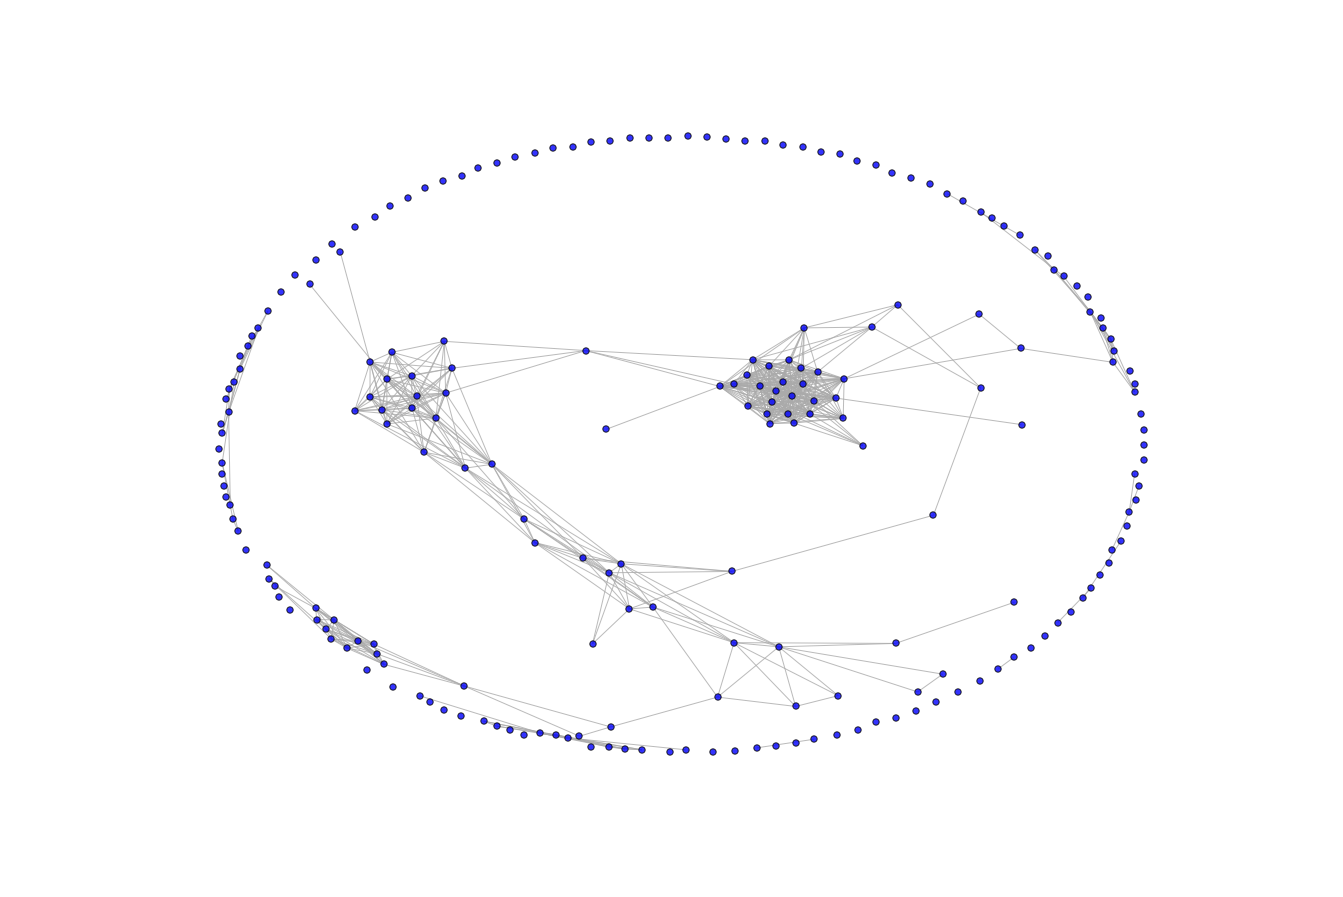

In [5]:
nx.draw(G, linewidths  = 1, node_size = 40, node_color = 'blue', edge_color = "#aaaaaa", alpha = 0.8)
plt.show()

In [6]:
H = nx.Graph(G)
graphs = list(nx.connected_component_subgraphs(H))
graphs.sort(key=lambda x: len( x.nodes() ), reverse = True)
GCC = graphs[0]

other_groups = []
for g in graphs:
    if len(g.nodes()) != len(GCC.nodes()):
        if len(g.nodes()) > 2:
            other_groups.append(g.nodes())
            
for o in other_groups:
    print o

[195, 179, 175, 176, 115, 116, 117, 119, 120, 59]
[144, 137, 172, 141, 48, 145, 146, 217]
[177, 178, 197, 47]
[192, 49, 198, 201]
[213, 214, 215]


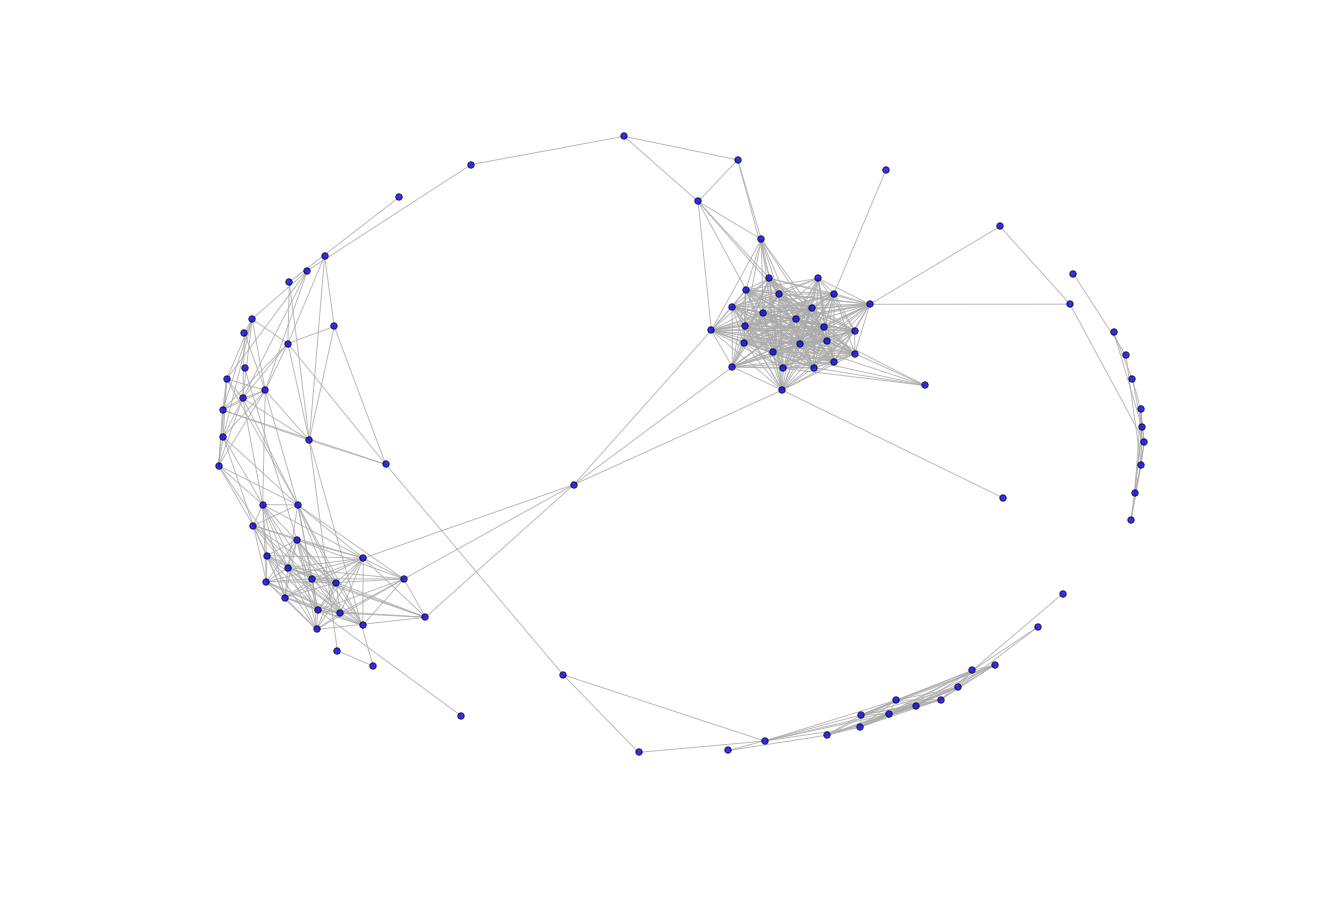

In [7]:
nx.draw(GCC, linewidths  = 1, node_size = 40, node_color = 'blue', edge_color = "#aaaaaa", alpha = 0.8)
plt.show()

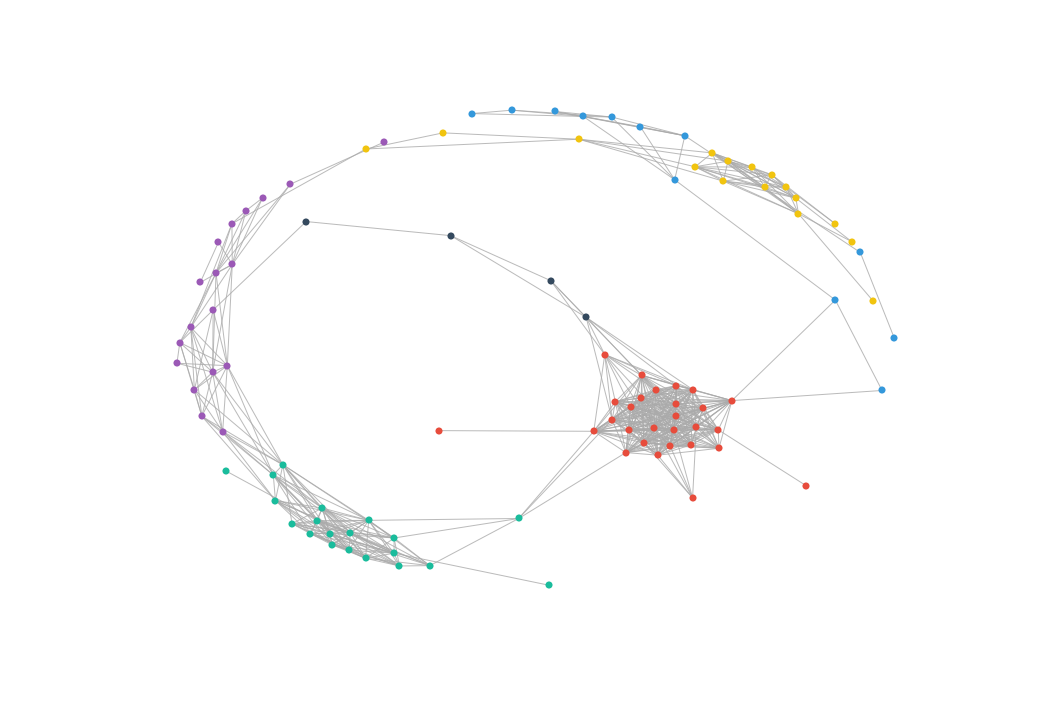

0.624684034806
6


In [28]:
import community
import matplotlib

colours = []
colours.append( "#7f8c8d")
colours.append( "#e74c3c")
colours.append( "#3498db")
colours.append( "#f1c40f")
colours.append( "#9b59b6")
colours.append( "#1abc9c")
colours.append( "#34495e")
colours.append( "#e67e22")
colours.append( "#7f8c8d")
colours.append( "#e74c3c")
colours.append( "#3498db")
colours.append( "#f1c40f")
colours.append( "#9b59b6")
colours.append( "#1abc9c")
colours.append( "#34495e")
colours.append( "#e67e22")
colours.append( "#7f8c8d")
colours.append( "#e74c3c")
colours.append( "#3498db")
colours.append( "#f1c40f")
colours.append( "#9b59b6")
colours.append( "#1abc9c")
colours.append( "#34495e")
colours.append( "#e67e22")
colours.append( "#7f8c8d")
colours.append( "#e74c3c")
colours.append( "#3498db")
colours.append( "#f1c40f")
colours.append( "#9b59b6")
colours.append( "#1abc9c")
colours.append( "#34495e")
colours.append( "#e67e22")


# matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)
#first compute the best partition
def computeModularity ( graph_undirect, sub_graphs):
    M = 0
    L = len( graph_undirect.edges() )
    for c in sub_graphs:
        kc = 0
        for n in c:
            kc+= c.degree(n)
        Lc = len( c.edges() )
        M += ( float( Lc / float(L) - pow( float(kc) / ( 2.0 * float(L) ) ,2) ))
    return M


partition = community.best_partition(GCC)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(GCC)
count = 0.
nx.draw_networkx_edges(GCC,pos,  edge_color = "#aaaaaa", alpha = 0.8)
sub_graphs_louvain = []

for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(GCC, pos, list_nodes, linewidths = 0,  node_size = 50,
                                node_color = colours[int(count)])
    #place partition in subgraphs
    sub_graphs_louvain.append( GCC.subgraph(list_nodes ) )


plt.axis('off')
plt.show()

print computeModularity ( GCC, sub_graphs_louvain)
print len(sub_graphs_louvain)

In [9]:
for g in sub_graphs_louvain:
    other_groups.append(g.nodes())

In [ ]:
communities = []
for n in graph['nodes']:
    id_db = n['id_db']
#     print db.documents.find_one( {"_id": id_db} )
#     print id_db
    id = n['id']
#     print id
    community = -1
    k = 0
    for sub in other_groups:
        if id in sub:
            community = k
        k += 1
        
#     print community
#     db.documents.update_one({"_id": str(id_db)},{"$set": {"community": community}})
    communities.append(community)
    
k = 0
new_nodes = []
for n in graph['nodes']:
    n['community'] = communities[k]
    new_nodes.append(n)
    k += 1
    
# for doc in db.documents.find():
#     db.documents.update_one({"_id": doc['_id']},{"$set": {"community": communities[k]}})
#     k += 1

In [ ]:
new_graph = graph
new_graph['nodes'] = new_nodes
db.graph.drop()
db.graph.insert(  new_graph )

# hyperconnected clusters

In [84]:
clusters = []
single_clusters = []
edges = G.edges()
added = []
for g in G.nodes():
    if g not in added:
        c = [g]
        for cc in clusters:
            if g in cc:
                c = cc
                clusters.remove(cc)
                break
        for gg in G.nodes():
            if gg not in added:
                ok = True
                for ggg in c:
                    if ((ggg,gg) not in edges) and ((ggg,g) not in edges):
                        ok = False
                if ok:
                    c.append(gg)
        added += c
        clusters.append(c)


bigger_clusters = []
single_clusters = []
for c in clusters:
    if len(set(c) )> 2:
        bigger_clusters.append(list(set(c) ) )
    else:
        single_clusters += list(set(c) )

In [85]:
for b in bigger_clusters:
    print b

print 
print single_clusters

[48, 145, 172]
[128, 129, 131, 132, 133, 165, 170, 54, 208, 88, 89, 90, 91, 92, 93, 121, 122, 123, 124, 125, 126, 127]
[176, 59, 179, 195, 119]
[187, 181, 62]
[64, 196, 112, 113, 114, 184, 219, 221]
[111, 68, 102, 95]
[160, 161, 118, 166, 168, 75, 148, 150, 156]
[96, 100, 94]
[104, 98, 107, 108, 109]
[154, 99, 163]
[120, 115, 117]
[137, 146, 217]
[153, 159, 151]
[204, 206, 191]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 178, 47, 49, 198, 50, 51, 52, 53, 55, 56, 139, 57, 58, 209, 60, 61, 63, 65, 66, 67, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 97, 105, 101, 110, 103, 106, 116, 130, 134, 167, 138, 135, 136, 147, 140, 141, 142, 143, 144, 149, 152, 157, 155, 164, 169, 158, 162, 171, 173, 174, 175, 177, 197, 194, 180, 182, 185, 183, 186, 190, 188, 189, 207, 192, 216, 193, 203, 199, 200, 201, 202, 205, 210, 211, 212, 213, 214,

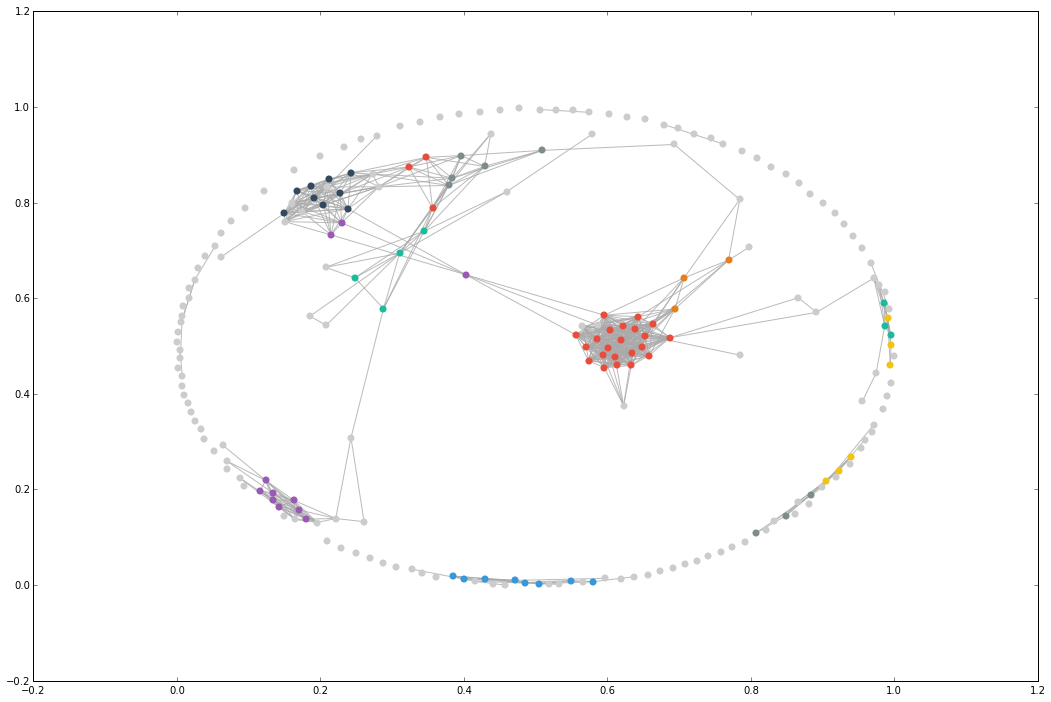

In [86]:
pos = nx.spring_layout(G)
count = 0.
nx.draw_networkx_edges(G,pos,  edge_color = "#aaaaaa", alpha = 0.8)

k = 0
for g in bigger_clusters:
    nx.draw_networkx_nodes(G, pos, g, linewidths = 0,  node_size = 50,
                                node_color = colours[k])
    k += 1
    
nx.draw_networkx_nodes(G, pos, single_clusters, linewidths = 0,  node_size = 50,
                                node_color = '#cccccc')

# update document in db

In [87]:

for n in graph['nodes']:
    id_db = n['id_db']
#     print db.documents.find_one( {"_id": id_db} )
#     print id_db
    id = n['id']
#     print id
    
new_nodes = []
i = 0
g_nodes = G.nodes()
for n in graph['nodes']:
    clus = -1
    k = 0
    for g in bigger_clusters:
        if g_nodes[i] in g:
            clus = k
        k += 1
    n['cluster'] = clus
    new_nodes.append(n)
    i += 1
    
# for doc in db.documents.find():
#     db.documents.update_one({"_id": doc['_id']},{"$set": {"community": communities[k]}})
#     k += 1

In [88]:
new_graph = graph
new_graph['nodes'] = new_nodes
db.graph.drop()
db.graph.insert(  new_graph )

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.


ObjectId('566587469f5c8d2494e4f78c')

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
-1
-1
-1
-1
-1
-1
-1
1
-1
2
-1
-1
-1
3
-1
-1
-1
-1
-1
-1
4
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
0
0
0
0
0
0
5
3
0
2
3
3
5
5


[u'translator', u'topicsGraph', u'full_text', u'title', u'significantWords', u'community', u'tokens', u'full_topics', u'complexity', u'_id', u'type', u'semantic_vec']


In [9]:
between = nx.betweenness_centrality(G)

In [16]:
for b in sorted( between, key = between.get, reverse = True )[:5]:
    print between[b]

0.0864361322841
0.053351573453
0.0525438326347
0.0505964623612
0.0449197860963


In [17]:
def drawHighlighted( GCC, points, labels = False ):
    pos = nx.fruchterman_reingold_layout(GCC)
    nx.draw(GCC, pos = pos, linewidths  = 1, node_size = 40, node_color = "#33CCFF" , edge_color = "#bbbbbb", alpha = 0.8)
    nx.draw_networkx_nodes(GCC, pos, nodelist = points, linewidths  = 1, node_size = 60, node_color = "#FF9933" , edge_color = "#bbbbbb", alpha = 0.9)
    if (labels):
        nx.draw_networkx_labels( GCC, pos = pos , alpha = 0.1)
    plt.show()
    return

the 5 philosophers with the highest betweeness centrality (graph):


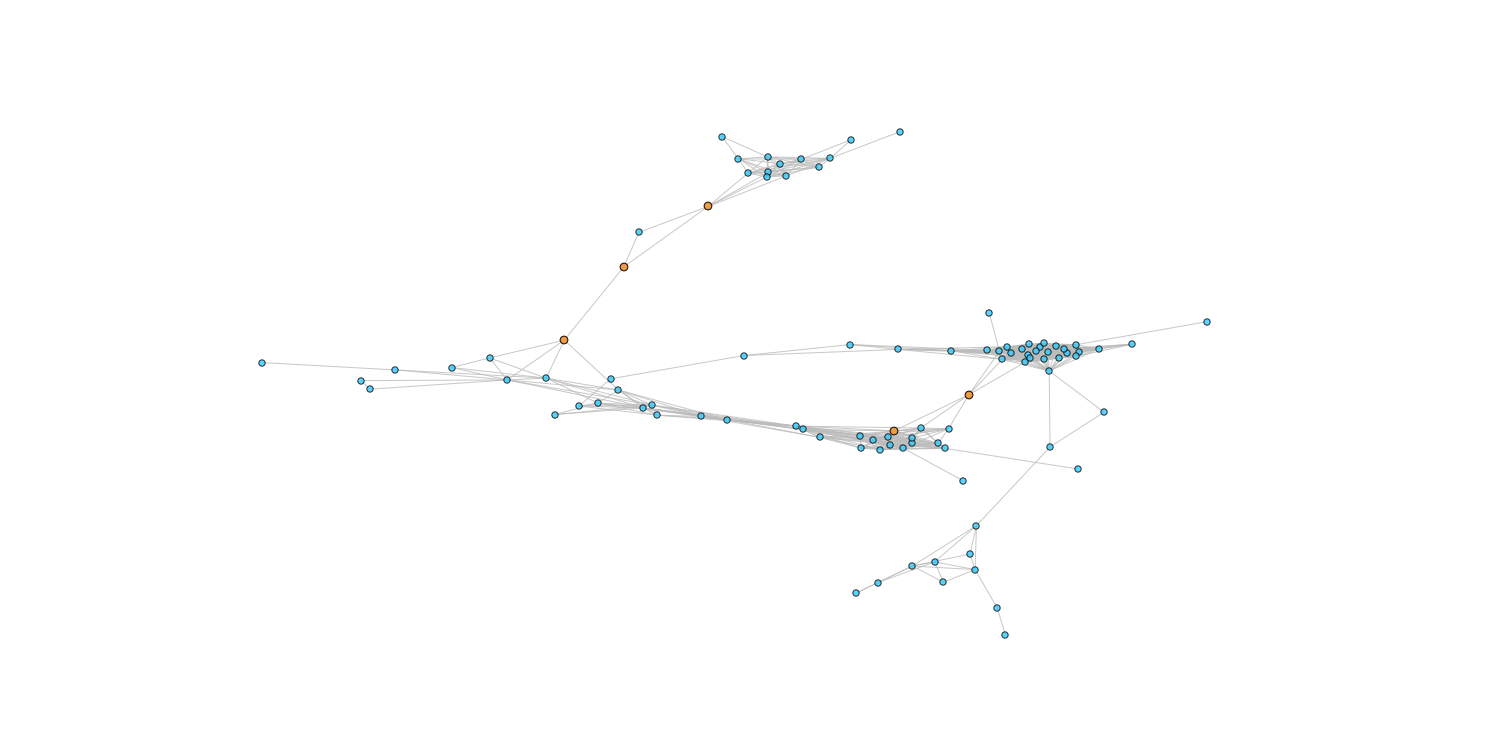

In [23]:

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
print "the 5 philosophers with the highest betweeness centrality (graph):"
drawHighlighted( GCC, sorted( between, key = between.get, reverse = True )[:5])

In [24]:
eigen = nx.eigenvector_centrality(G)

In [30]:
for b in sorted( eigen, key = eigen.get, reverse = True )[:5]:
    print eigen[b]

0.210677763346
0.210677763346
0.210107465844
0.210107465844
0.208365352399


the 5 philosophers with the highest betweeness centrality (graph):


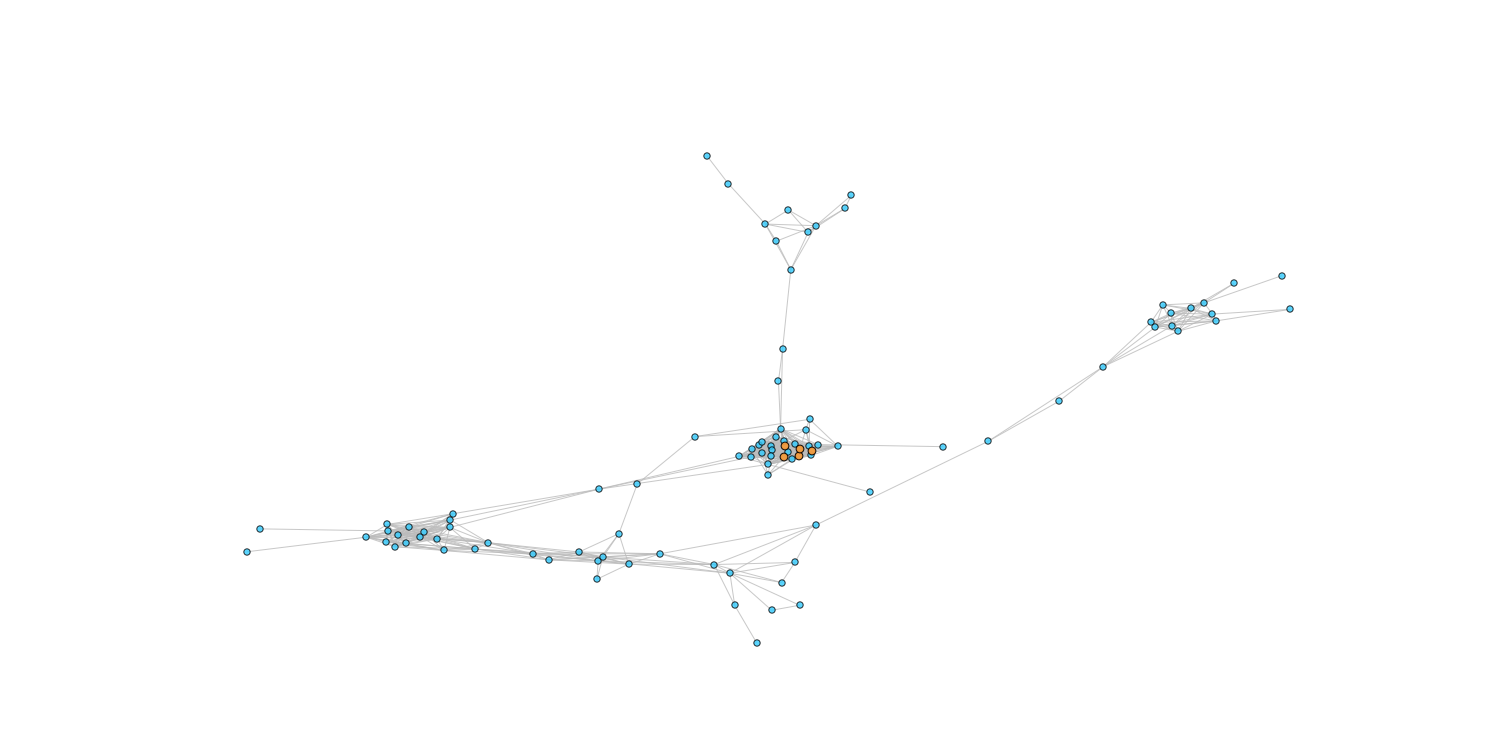

In [28]:

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
print "the 5 philosophers with the highest betweeness centrality (graph):"
drawHighlighted( GCC, sorted( eigen, key = eigen.get, reverse = True )[:5])